In [1]:
# Deep Learning
from skorch import NeuralNetClassifier
from skorch.callbacks import Checkpoint
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# Adversarials
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod

# Stats and Math
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Utilities
import matplotlib.pyplot as plt
import pickle



torch.Size([60000, 1, 28, 28])
torch.Size([60000])
cuda:0


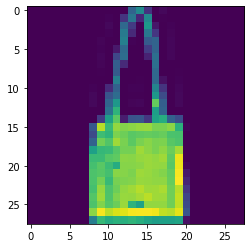

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

download_data = False # set to true if running for first time
trainset = torchvision.datasets.FashionMNIST(root="./data",train=True, download=download_data, transform=transforms.ToTensor())
testset = torchvision.datasets.FashionMNIST(root="./data",train=False, download=download_data, transform=transforms.ToTensor())

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# *** NOTE *** 
# If using skorch don't need to set to CUDA right now will do it for you
# Otherwise for pytorch add .to(device) to all tensors
X_train = trainset.data.reshape(-1, 1, 28, 28).type(torch.float32)/255
X_test = (testset.data.reshape(-1, 1, 28, 28).type(torch.float32)/255).numpy()
y_train = trainset.targets
y_test = testset.targets.numpy()
plt.imshow(X_train[200,0,:,:].cpu())
print(X_train.shape)
print(y_train.shape)
print(device)

In [3]:
class Fashion_Model(nn.Module):
    def __init__(self):
        super(Fashion_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 4, 3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(7*7*4, 100)
        self.out = nn.Linear(100, 10)
        
    def forward(self, X, **kwargs):
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        X = torch.flatten(X, start_dim=1)
        X = F.relu(self.fc1(X))
        X = self.out(X)
        X = F.softmax(X, dim=-1)

        return X

models_dir = 'models/'
model_name = 'test'
cp_file = "{}model_{}.p".format(models_dir, model_name)
cp = Checkpoint(f_params=None, f_optimizer=None, f_history=None,f_pickle=cp_file)
net = NeuralNetClassifier(
    Fashion_Model,
    max_epochs=100,
    lr=0.01,
    batch_size=128,
    device=device,
    callbacks=[cp],
)


In [4]:
net.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        1.9038       0.6484        0.9368     +  1.2701


/home/adrian/projects/env_adv/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Fashion_Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/adrian/projects/env_adv/lib/python3.6/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


      2        0.8182       0.7153        0.8029     +  1.2331
      3        0.7085       0.7341        0.7006     +  1.2423
      4        0.6501       0.7538        0.6396     +  1.2435
      5        0.6116       0.7715        0.5985     +  1.2335
      6        0.5827       0.7813        0.5711     +  1.2403
      7        0.5596       0.7915        0.5485     +  1.2437
      8        0.5398       0.7964        0.5315     +  1.2421
      9        0.5224       0.8111        0.5072     +  1.2425
     10        0.5067       0.8162        0.4961     +  1.2419
     11        0.4930       0.8230        0.4819     +  1.2437
     12        0.4813       0.8269        0.4715     +  1.2431
     13        0.4707       0.8298        0.4633     +  1.2378
     14        0.4613       0.8333        0.4543     +  1.2369
     15        0.4523       0.8347        0.4460     +  1.2368
     16        0.4445       0.8367        0.4419     +  1.2388
     17        0.4372       0.8380        0.4362     + 

     98        0.2501       0.8919        0.2981     +  1.3909
     99        0.2491       0.8911        0.2987        1.3777
    100        0.2482       0.8913        0.2990        1.3802


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Fashion_Model(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=196, out_features=100, bias=True)
    (out): Linear(in_features=100, out_features=10, bias=True)
  ),
)

In [5]:
with open(cp_file, 'rb') as f:
    net = pickle.load(f)

In [6]:
y_pred_proba = net.predict_proba(X_test)
y_pred = net.predict(X_test)

def classification_results(y_true, y_pred):
    acc = np.sum(y_true == y_pred) / len(y_true)
    mae = np.mean(np.abs(y_true-y_pred)) 
    cm = confusion_matrix(y_true, y_pred)
    class_acc = cm.diagonal()/cm.sum(axis=1)

    print("Accuracy: {}".format(acc))
    print("MAE: {}".format(mae))
    print("confusion matrix: (Truth x Pred)")
    print(cm)
    print("class accuracies")
    print(class_acc)
    print(classification_report(y_true, y_pred, target_names=class_names))

classification_results(y_true=y_test, y_pred=y_pred)

Accuracy: 0.886
MAE: 0.3834
confusion matrix: (Truth x Pred)
[[893   0  32  22   3   0  37   0  13   0]
 [  3 964   1  26   2   0   3   0   1   0]
 [ 17   1 872   8  56   0  42   0   4   0]
 [ 34   5  11 910  16   0  18   0   6   0]
 [  1   1  94  48 809   0  44   0   3   0]
 [  1   0   2   0   0 949   0  31   1  16]
 [205   2 110  30  76   0 561   0  16   0]
 [  0   0   0   0   0  13   0 962   1  24]
 [  4   1   3   7   3   0   0   3 978   1]
 [  1   0   0   1   0   2   1  33   0 962]]
class accuracies
[0.893 0.964 0.872 0.91  0.809 0.949 0.561 0.962 0.978 0.962]
              precision    recall  f1-score   support

 T-shirt/top       0.77      0.89      0.83      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.78      0.87      0.82      1000
       Dress       0.87      0.91      0.89      1000
        Coat       0.84      0.81      0.82      1000
      Sandal       0.98      0.95      0.97      1000
       Shirt       0.79      0.56      0.66      1

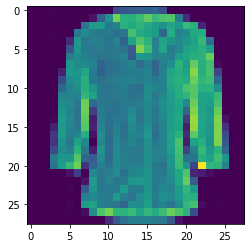

In [7]:
i_shirts = np.argwhere(y_test == 6)
X_shirts = X_test[i_shirts[:,0],:,:,:]
y_shirts = y_test[i_shirts]
plt.imshow(X_shirts[0,0,:,:])

In [8]:
from sklearn.preprocessing import OneHotEncoder

In [9]:
target_class = 6
targets = y_test
targets[targets==targets] = 0
onehot_encoder = OneHotEncoder(sparse=False)
targets_encoded = targets.reshape(len(targets), 1)
targets_encoded = onehot_encoder.fit_transform(targets_encoded)
print(targets)
print(targets_encoded)

[0 0 0 ... 0 0 0]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [10]:
# Create Adversarial Patch
epsilon = 0.2
classifier = PyTorchClassifier(clip_values=(0, 1), model=net.module_, loss=net.criterion_, input_shape=(28,28), nb_classes=10)
crafter = FastGradientMethod(classifier, eps=epsilon, targeted=True)

In [11]:
X_test_adv = crafter.generate(X_test, y=targets_encoded)

(10000, 1, 28, 28)


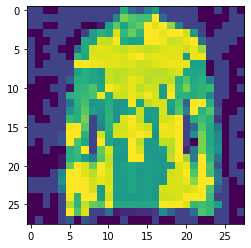

In [19]:
print(X_test_adv.shape)
plt.imshow(X_test_adv[i_shirts[2,0],0,:,:])

In [ ]:
y_pred_adv = net.predict(X_test_adv)
classification_results(y_true=y_test, y_pred=y_pred_adv)

In [ ]:
net_pt = net.module_
net_pt.__dict__
#net_pt._parameters.__dict__

In [ ]:
# Extra Code Backups



for i in range(28):
    for j in range(28):
        with open('img.txt', 'a') as file:
            file.write(str(int(img[i,j])) + '  ')
    with open('img.txt', 'a') as file:
            file.write('\n')